In [1]:
import pandas as pd
import numpy as np
import jieba
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
# 读取数据
df = pd.read_csv()

In [3]:
df.head()

,标题,日期
0,中乌联合考古揭开古丝绸之路千年遗存神秘面纱,2024/6/19
1,中尼舞者“以舞会友”促文化交流,2024/6/10
2,心相近｜这所高校为海外学子打开“中国之窗”,2024/6/4
3,“茶和天下·雅集”暨中国（广西）文化旅游推介会在科伦坡举行,2024/5/23
4,中国图书首次正式亮相多哈国际书展,2024/5/14


In [4]:
# 定义一个函数，用于去除特殊符号、标点符号等，并只保留汉字  
def clean_text(text):  
    # 使用正则表达式去除非汉字字符  
    cleaned_text = re.sub(r'[^\u4e00-\u9fa5]', '', text)  
    return cleaned_text

In [5]:
# 应用clean_text函数到'标题'列，并创建一个新的列'新标题'  
df['新标题'] = df['标题'].apply(clean_text)

In [6]:
# 接下来进行分词和去停用词（如果需要的话）  
def tokenize_text(text):  
    # 假设你有一个停用词文件  
    stopwords = set([line.strip() for line in open('stopwords.txt', encoding='utf-8').readlines()])  
    words = jieba.cut(text, cut_all=False)  
    filtered_words = [word for word in words if word not in stopwords and len(word) > 1]  # 排除单字符词  
    return ' '.join(filtered_words)

In [7]:
# 应用tokenize_text函数到'新标题'列，并创建一个新的列'新标题2'  
df['新标题2'] = df['新标题'].apply(tokenize_text)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\hhhh\AppData\Local\Temp\jieba.cache
Loading model cost 0.705 seconds.
Prefix dict has been built successfully.


In [8]:
df['新标题3'] = df['新标题2'].apply(lambda x: x.split())

In [9]:
df.head()

,标题,日期,新标题,新标题2,新标题3
0,中乌联合考古揭开古丝绸之路千年遗存神秘面纱,2024/6/19,中乌联合考古揭开古丝绸之路千年遗存神秘面纱,中乌 联合 考古 揭开 丝绸之路 千年 遗存 神秘 面纱,"[中乌, 联合, 考古, 揭开, 丝绸之路, 千年, 遗存, 神秘, 面纱]"
1,中尼舞者“以舞会友”促文化交流,2024/6/10,中尼舞者以舞会友促文化交流,中尼 舞者 舞会 友促 文化交流,"[中尼, 舞者, 舞会, 友促, 文化交流]"
2,心相近｜这所高校为海外学子打开“中国之窗”,2024/6/4,心相近这所高校为海外学子打开中国之窗,相近 这所 高校 海外 学子 打开 中国 之窗,"[相近, 这所, 高校, 海外, 学子, 打开, 中国, 之窗]"
3,“茶和天下·雅集”暨中国（广西）文化旅游推介会在科伦坡举行,2024/5/23,茶和天下雅集暨中国广西文化旅游推介会在科伦坡举行,天下 雅集 中国 广西 文化 旅游 推介会 科伦坡,"[天下, 雅集, 中国, 广西, 文化, 旅游, 推介会, 科伦坡]"
4,中国图书首次正式亮相多哈国际书展,2024/5/14,中国图书首次正式亮相多哈国际书展,中国 图书 首次 正式 亮相 多哈 国际 书展,"[中国, 图书, 首次, 正式, 亮相, 多哈, 国际, 书展]"


# 文本数据向量化

In [10]:
# 使用TF-IDF将文本转化为矩阵
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['新标题2'])

In [11]:
tfidf_matrix

<297x956 sparse matrix of type '<class 'numpy.float64'>'
	with 1898 stored elements in Compressed Sparse Row format>

# 确定最佳主题数目

## 困惑度得分

In [12]:
perplexity_scores = []
n_topics_range = range(2, 21)

for n_topics in n_topics_range:
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(tfidf_matrix)
    perplexity_scores.append(lda.perplexity(tfidf_matrix))

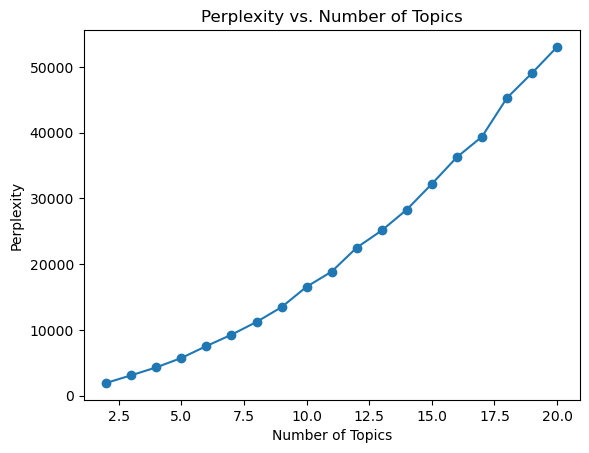

最佳主题数目（困惑度最低）:  2


In [13]:
# 绘制困惑度图
plt.plot(n_topics_range, perplexity_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.title('Perplexity vs. Number of Topics')
plt.show()

# 打印困惑度最低的主题数目
optimal_num_topics = n_topics_range[perplexity_scores.index(min(perplexity_scores))]
print("最佳主题数目（困惑度最低）: ", optimal_num_topics)

# 开始正式建模LDA

In [40]:
# 设置主题数目
num_topics = 3  # 这里假设选择10个主题

In [41]:
# 训练LDA模型
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(tfidf_matrix)

LatentDirichletAllocation(n_components=3, random_state=42)

In [42]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [43]:
# 打印每个主题的前10个关键词
print_top_words(lda_model, vectorizer.get_feature_names_out(), 10)

Topic #0:
一带 中国 一路 举办 论坛 丝路 合作 文化 亮相 活动
Topic #1:
中国 文化 丝绸之路 一路 一带 马来西亚 丝路 海上 主题 文化交流
Topic #2:
中国 比赛 全球 连线 汉语 文化 一路 一带 铁路 中文



# 获取主题-文档矩阵

In [44]:
# 获取主题-文档矩阵
doc_topic_matrix = lda_model.transform(tfidf_matrix)

In [45]:
# 将矩阵转换为 DataFrame
doc_topic_df = pd.DataFrame(doc_topic_matrix)
doc_topic_df.columns = [f"Topic_{i}" for i in range(num_topics)]
doc_topic_df.index = df.index

In [46]:
doc_topic_df.head()

,Topic_0,Topic_1,Topic_2
0,0.085308,0.827481,0.087212
1,0.106829,0.114174,0.778998
2,0.095627,0.806581,0.097792
3,0.777518,0.128368,0.094113
4,0.784447,0.095714,0.119838


# 获取主题-关键词矩阵

In [47]:
# 获取主题-关键词矩阵
topic_word_matrix = lda_model.components_

In [48]:
# 将矩阵转换为 DataFrame
feature_names = vectorizer.get_feature_names_out()
topic_word_df = pd.DataFrame(topic_word_matrix)
topic_word_df.columns = feature_names
topic_word_df.index = [f"Topic_{i}" for i in range(num_topics)]

In [49]:
# topic_word_df

# 获取指定帖子在各个主题上的概率分布

In [50]:
def get_topic_distribution(lda_model, tfidf_matrix, doc_index):
    """
    获取指定帖子在各个主题上的概率分布

    参数:
    lda_model: 已训练的LDA模型
    tfidf_matrix: TF-IDF矩阵
    doc_index: 帖子在TF-IDF矩阵中的索引

    返回:
    帖子的主题概率分布
    """
    # 选择指定帖子
    doc_tfidf = tfidf_matrix[doc_index]

    # 计算该帖子的主题概率分布
    doc_topic_dist = lda_model.transform(doc_tfidf)

    # 打印该帖子的主题概率分布
    print(f"帖子#{doc_index}的主题概率分布:")
    for topic_idx, topic_prob in enumerate(doc_topic_dist[0]):
        print(f"主题#{topic_idx}: {topic_prob:.4f}")

    return doc_topic_dist[0]

In [51]:
# 选择某一条帖子（例如第一条）
doc_index = 100

# 获取该帖子的主题概率分布
print(f"帖子#{doc_index}的内容为:", df['标题'][doc_index])
topic_distribution = get_topic_distribution(lda_model, tfidf_matrix, doc_index)

帖子#100的内容为: 留学生“一带一路”乐队：把中国唱给世界听
帖子#100的主题概率分布:
主题#0: 0.1288
主题#1: 0.7564
主题#2: 0.1148


# 获取每个主题下代表性的前5个文档

In [52]:
# 获取所有帖子在各个主题上的概率分布
doc_topic_dists = lda_model.transform(tfidf_matrix)

In [53]:
# 获取每个主题的前五个代表性文档
top_docs_per_topic = {}
for topic_idx in range(num_topics):
    # 获取当前主题的所有文档概率
    topic_probs = doc_topic_dists[:, topic_idx]
    # 获取概率最高的前五个文档索引
    top_doc_indices = topic_probs.argsort()[-5:][::-1]
    top_docs_per_topic[topic_idx] = top_doc_indices

In [54]:
# 打印每个主题的前五个代表性文档
for topic_idx, doc_indices in top_docs_per_topic.items():
    print(f"主题#{topic_idx}的前五个代表性文档:")
    for doc_index in doc_indices:
        print(f"文档索引: {doc_index}, 标题: {df['标题'][doc_index]}")
    print()

主题#0的前五个代表性文档:
文档索引: 21, 标题: 澜湄合作国际设计大赛优秀作品展暨冬至文化体验活动在京举办
文档索引: 218, 标题: “光影里的故事”探讨“一带一路”促中国影视发展讲座在悉尼举办
文档索引: 160, 标题: 陈竺在第四届“一带一路”中医药发展论坛上发表视频致辞
文档索引: 224, 标题: 斐济高校成功举办南太平洋岛国与“一带一路”倡议研讨会
文档索引: 138, 标题: 巴基斯坦举办论坛呼吁巴中媒体加强合作打击假新闻

主题#1的前五个代表性文档:
文档索引: 0, 标题: 中乌联合考古揭开古丝绸之路千年遗存神秘面纱
文档索引: 221, 标题: 首部“一带一路”纪录影片《共同命运》在威尼斯电影节举办推介会
文档索引: 205, 标题: 通讯：中文交往与海上丝路的历史见证——访文莱海事博物馆
文档索引: 195, 标题: 开罗老咖啡馆——埃及文豪马赫福兹的灵感之地
文档索引: 192, 标题: 中国驻克罗地亚大使馆与华侨华人举办元宵节慈善晚宴

主题#2的前五个代表性文档:
文档索引: 282, 标题: 这位巴西孔院院长希望用30年培养出一批“知华派”
文档索引: 51, 标题: 中企参建"地铁学校"在哥伦比亚首都波哥大"开课"
文档索引: 20, 标题: 中企承建的铁路成为尼日利亚假日出行热门选择
文档索引: 194, 标题: 中埃两国企业签署12部中国图书阿语版权协议
文档索引: 7, 标题: “在火车上体验中国书法真有趣”——“兰亭·雅集”中国书法主题活动走进中老铁路



# 确定每一条帖子的概率最大的主题，并写入数据框

In [55]:
# 封装获取主要主题的函数
def get_main_topic(lda_model, tfidf_matrix):
    """
    获取每条帖子的主要主题，并返回主题列表

    参数:
    lda_model: 已训练的LDA模型
    tfidf_matrix: TF-IDF矩阵

    返回:
    每条帖子的主要主题列表
    """
    # 获取所有帖子在各个主题上的概率分布
    doc_topic_dists = lda_model.transform(tfidf_matrix)

    # 计算每条帖子的主要主题
    main_topics = doc_topic_dists.argmax(axis=1)
    
    return main_topics

In [56]:
# 获取每条帖子的主要主题
main_topics = get_main_topic(lda_model, tfidf_matrix)

In [57]:
# 将主要主题添加到数据框中
df['主要主题'] = main_topics

In [58]:
df.head()

,标题,日期,新标题,新标题2,新标题3,主要主题
0,中乌联合考古揭开古丝绸之路千年遗存神秘面纱,2024/6/19,中乌联合考古揭开古丝绸之路千年遗存神秘面纱,中乌 联合 考古 揭开 丝绸之路 千年 遗存 神秘 面纱,"[中乌, 联合, 考古, 揭开, 丝绸之路, 千年, 遗存, 神秘, 面纱]",1
1,中尼舞者“以舞会友”促文化交流,2024/6/10,中尼舞者以舞会友促文化交流,中尼 舞者 舞会 友促 文化交流,"[中尼, 舞者, 舞会, 友促, 文化交流]",2
2,心相近｜这所高校为海外学子打开“中国之窗”,2024/6/4,心相近这所高校为海外学子打开中国之窗,相近 这所 高校 海外 学子 打开 中国 之窗,"[相近, 这所, 高校, 海外, 学子, 打开, 中国, 之窗]",1
3,“茶和天下·雅集”暨中国（广西）文化旅游推介会在科伦坡举行,2024/5/23,茶和天下雅集暨中国广西文化旅游推介会在科伦坡举行,天下 雅集 中国 广西 文化 旅游 推介会 科伦坡,"[天下, 雅集, 中国, 广西, 文化, 旅游, 推介会, 科伦坡]",0
4,中国图书首次正式亮相多哈国际书展,2024/5/14,中国图书首次正式亮相多哈国际书展,中国 图书 首次 正式 亮相 多哈 国际 书展,"[中国, 图书, 首次, 正式, 亮相, 多哈, 国际, 书展]",0


In [59]:
# df.to_csv(r'D:\EasySpider_windows_x32\Data\Task_0\一带一路中新网2.csv')

In [60]:
import pyLDAvis
import pyLDAvis.lda_model

In [61]:
# 可视化
vis = pyLDAvis.lda_model.prepare(lda_model, tfidf_matrix, vectorizer)
# 在 Jupyter Notebook 中显示
pyLDAvis.display(vis)